# Computer Vision - Face Recognition# 

In [344]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import warnings; warnings.filterwarnings('ignore')

import pathlib
import cv2
import PIL
import glob

from zipfile import ZipFile

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tqdm.notebook import tqdm
import matplotlib.gridspec as gridspec
import random

In [11]:
print(tf.__version__)

2.4.1


In [12]:
# Change directory and view files/folders
print(os.listdir("/Users/Rakesh Gowda S N/Documents/Projects/Project 9 - Advanced CNN/Part 2/"))

['Part 2 - Aligned Face Dataset from Pinterest.zip', 'Part 2 - vgg_face_weights.h5', 'Part 2 Test Images']


## Import data and create meta data

In [16]:
os.chdir("/Users/Rakesh Gowda S N/Documents/Projects/Project 9 - Advanced CNN/Part 2/")

In [17]:
# Extract zip file
with ZipFile('Part 2 - Aligned Face Dataset from Pinterest.zip', 'r') as zip:
  zip.extractall()

In [18]:
# Create meta data
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts

metadata, exts = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

In [19]:
# Load images
def load_image(path):
    img = cv2.imread(path, 1)
    # Images are loaded in BGR order. Reverse them
    return img[...,::-1]

In [20]:
n = np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
img = load_image(img_path)

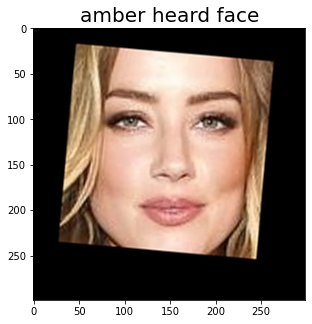

In [21]:
# View sample image
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)
plt.imshow(img);

## Load the pre-trained model and weights

In [22]:
def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape = (224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides =(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    
    return model

In [23]:
model = vgg_face()
model.load_weights('Part 2 - vgg_face_weights.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

In [24]:
vgg_face_descriptor = Model(inputs = model.layers[0].input, outputs = model.layers[-2].output)

## Generate Embedding vectors for each face in the dataset

In [25]:
img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalizing pixel values from [0-255] to [0-1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224, 224))
print("The shape of the image is {}".format(img.shape))

# Obtain and get the embedding vector for the above image using vgg_face_descriptor model
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
print("The shape of the Embedded vector is {}".format(embedding_vector.shape))

The shape of the image is (224, 224, 3)
The shape of the Embedded vector is (2622,)


In [26]:
# Generate embeddings
embdngs = []
embdngs = np.zeros((metadata.shape[0], 2622))
for i, meta in tqdm(enumerate(metadata)):
  try:
    image = load_image(str(meta))
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embdngs[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embdngs[i] = np.zeros(2622)

## Building distance metrics

In [27]:
# Defining distance metric (Squared Euclidean distance)
def dist(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [31]:
def show_pair(idx1, idx2):
    plt.figure(figsize = (8, 3))
    plt.suptitle(f'Distance = {dist(embdngs[idx1], embdngs[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))

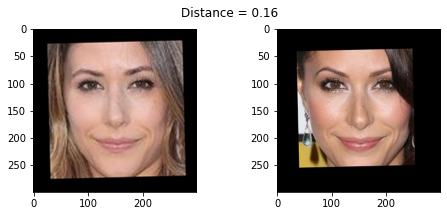

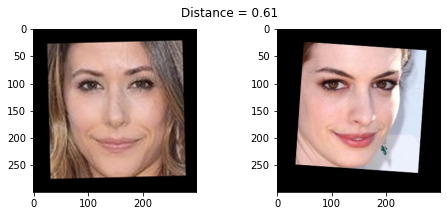

In [40]:
# Display images and ditance between them
show_pair(568, 586)
show_pair(568, 1024)

In [43]:
# Split into train and test data
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Features
X_train = np.array(embdngs)[train_idx]
X_test = np.array(embdngs)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

print("Shapes of train and test data are {}, {}, {} and {}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

Shapes of train and test data are (9320, 2622), (1166, 2622), (9320,) and (1166,)


In [44]:
# Label encoding
enc = LabelEncoder()
y_train = enc.fit_transform(y_train)
y_test = enc.transform(y_test)

In [45]:
# Standarizing features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

## Dimensionality reduction using PCA

In [47]:
# Covariance matrix
cvar_mat = np.cov(X_train_sc.T)
print("Shape of Covariance Matrix:",cvar_mat.shape)

# Finding Eigen values and Eigen vectors
eigen_vals, eigen_vecs = np.linalg.eig(cvar_mat)

# Finding variance explained in percentage
tot = sum(eigen_vals)

# Individual explained variance
var_exp = [(i /tot) * 100 for i in sorted(eigen_vals, reverse = True)]

# Cumulative explained variance
cvar_exp = np.cumsum(var_exp)

print('Explained Cumulative Variance is ', cvar_exp)

Shape of Covariance Matrix: (2622, 2622)
Explained Cumulative Variance is  [ 13.54529047  19.02462685  23.06968139 ...  99.99999983  99.99999999
 100.        ]


In [48]:
# Get index where cumulative variance explained is > threshold
thresh = 95
res = list(filter(lambda i: i > thresh, cvar_exp))[0]
index = (cvar_exp.tolist().index(res))
print(f'Index of element just greater than {thresh}: {str(index)}')

Index of element just greater than 95: 346


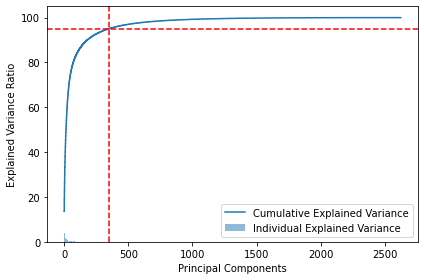

In [51]:
# Plotting explained variance
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')

plt.bar(range(1, eigen_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual Explained Variance')
plt.step(range(1, eigen_vals.size + 1), cvar_exp, where = 'mid', label = 'Cumulative Explained Variance')
plt.axhline(y = thresh, color = 'r', linestyle = '--')
plt.axvline(x = index, color = 'r', linestyle = '--')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [55]:
# Reducing the dimensions
pca = PCA(n_components = index, random_state = 7, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
print("Shape of dimensionally reduced data {}, {}".format(X_train_pca.shape, X_test_pca.shape))

Shape of dimensionally reduced data (9320, 346), (1166, 346)


## Building SVM classifier

In [345]:
svc = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = 7)
svc.fit(X_train_pca, y_train)
print('SVC accuracy for train dataset is: {0:.2f}'.format(svc.score(X_train_pca, y_train)))

SVC accuracy for train dataset is: 0.99


In [58]:
# Predict
y_pred = svc.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(2)))

Accuracy Score: 0.96


In [59]:
# Classification Report for each person
names = [name.split('_')[1].title().strip() for name in labels]
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      1.00      1.00        10
      Alexandra Daddario       0.91      1.00      0.95        10
            Alvaro Morte       1.00      1.00      1.00        14
Alycia Debnam Carey Face       1.00      1.00      1.00        12
             Amanda Crew       1.00      1.00      1.00         7
          Amaury Nolasco       0.89      0.89      0.89         9
        Amber Heard Face       1.00      1.00      1.00         7
               Anna Gunn       0.93      1.00      0.97        14
           Anne Hathaway       1.00      1.00      1.00        14
     Barbara Palvin Face       1.00      1.00      1.00         9
      Bellamy Blake Face       0.87      0.93      0.90        14
    Benedict Cumberbatch       1.00      1.00      1.00        12
            Betsy Brandt       1.00      1.00      1.00        10
              Bill Gates       0.82      0.90      

## Predicting the face on test images

In [346]:
# Create meta data
class t_IdentityMetadata():
    def __init__(self, base, name, file):
#         print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.t_image_path()

    def t_image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def t_load_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(t_IdentityMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts

metadata, exts = t_load_metadata('Part 2 Test Images')
labels = np.array([meta.name for meta in metadata])

In [285]:
# Load images
def t_load_image(path):
    img = cv2.imread(path, 1)
#     print(path)
    # Images are loaded in BGR order. Reverse them
    return img[...,::-1]

In [286]:
n = np.random.randint(1, len(metadata))
img_path = metadata[n].t_image_path()
img = t_load_image(img_path)

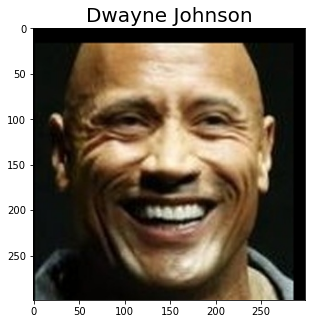

In [287]:
# View sample image
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)
plt.imshow(img);

In [324]:
t1_idx = np.arange(metadata.shape[0]) % 9 == 0
t2_idx = np.arange(metadata.shape[0]) % 9 == 1

In [341]:
def sample_img_plot(sample_idx):
  # Load image for sample_idx from test data
  sample_img = t_load_image(metadata[t1_idx][sample_idx].t_image_path())
  # Get actual name
  actual_name = metadata[t1_idx][sample_idx].name.split('_')[-1].title().strip()
  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_scaled = sc.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = svc.predict(pca.transform(embedding_scaled))
  # Transform back
  pred_name = enc.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, actual_name, pred_name

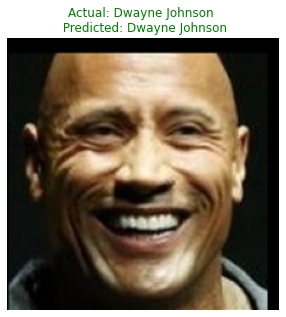

In [339]:
# Plot for images in test data
sample_img, actual_name, pred_name = sample_img_plot(0)
fig = plt.figure(figsize = (10, 5))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"Actual: {actual_name} \n Predicted: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

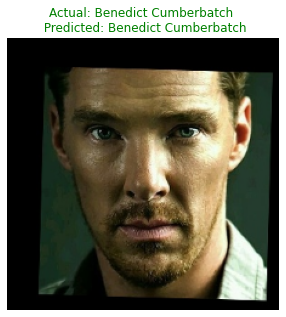

In [343]:
# Plot for images in test data
sample_img, actual_name, pred_name = sample_img_plot(0)
fig = plt.figure(figsize = (10, 5))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"Actual: {actual_name} \n Predicted: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()